In [19]:
# Load Biospytial modules and etc.
%matplotlib inline
import sys
sys.path.append('/apps')
import django
django.setup()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
## Use the ggplot style
plt.style.use('ggplot')

In [20]:
from external_plugins.spystats import tools

In [21]:
# My mac
#data = pd.read_csv("/RawDataCSV/plotsClimateData_11092017.csv")
# My Linux desktop
data = pd.read_csv("/RawDataCSV/idiv_share/plotsClimateData_11092017.csv")


In [22]:
%time new_data = tools.toGeoDataFrame(pandas_dataframe=data,xcoord_name='LON',ycoord_name='LAT')

CPU times: user 1.63 s, sys: 0 ns, total: 1.63 s
Wall time: 1.63 s


## Let´s reproject to Alberts or something with distance

### Uncomment to reproject
proj string taken from: http://spatialreference.org/

In [23]:
new_data =  new_data.to_crs("+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 +lon_0=-96 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs ")

## Add log of the Biomass

In [24]:
new_data['logBiomass'] = new_data.apply(lambda x : np.log(x.plotBiomass),axis=1)

In [25]:
new_data['newLon'] = new_data.apply(lambda c : c.geometry.x, axis=1)
new_data['newLat'] = new_data.apply(lambda c : c.geometry.y, axis=1)

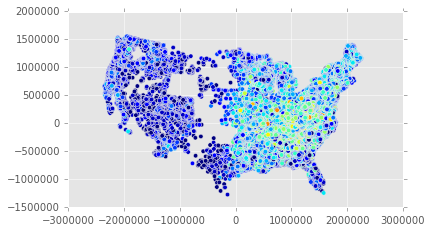

In [26]:
new_data.plot(column='SppN')

In [27]:
new_data['logBiomass'] = np.log(new_data.plotBiomass)

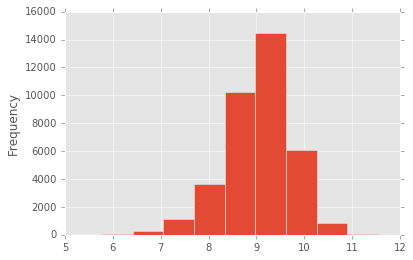

In [28]:
new_data.logBiomass.plot.hist()

## Linear Regression

In [29]:
### Now with statsmodels.api

#xx = X.SppN.values.reshape(-1,1)
#xx = sm.add_constant(xx)
#model = sm.OLS(Y.values.reshape(-1,1),xx)
import statsmodels.formula.api as smf
model = smf.ols(formula='logBiomass ~ SppN',data=new_data)
results = model.fit()
param_model = results.params
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             logBiomass   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     4187.
Date:                Thu, 09 Nov 2017   Prob (F-statistic):               0.00
Time:                        18:58:08   Log-Likelihood:                -36924.
No. Observations:               36845   AIC:                         7.385e+04
Df Residuals:                   36843   BIC:                         7.387e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      8.6217      0.007   1178.320      0.000         8.607     8.636
SppN           0.0807      0.001     64.709      0.000         0.078     0.083
==============================================================================
Omnibus:                     1709.757   Durbin-Watson:                   1.700
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2473.616
Skew:                          -0.437   Prob(JB):                         0.00
Kurtosis:                       3.921   Cond. No.                         12.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
new_data['residuals1'] = results.resid

# STOPPPP!!

## The area is very big -> 35000 points. 
We need to make a subset of this


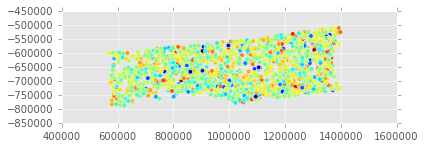

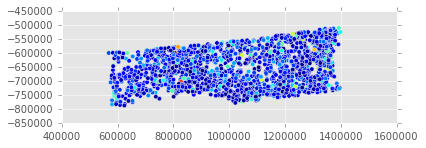

In [31]:
# COnsider the the following subregion
section = new_data[lambda x:  (x.LON > -90) & (x.LON < -80) & (x.LAT > 30) & (x.LAT < 32) ]
section.plot(column='residuals1')
section.plot(column='plotBiomass')

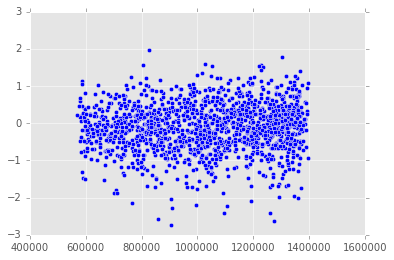

In [32]:
plt.scatter(section.newLon,section.residuals1)

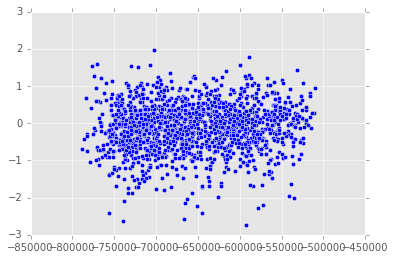

In [33]:
plt.scatter(section.newLat,section.residuals1)

CPU times: user 41.3 s, sys: 900 ms, total: 42.2 s
Wall time: 42.2 s


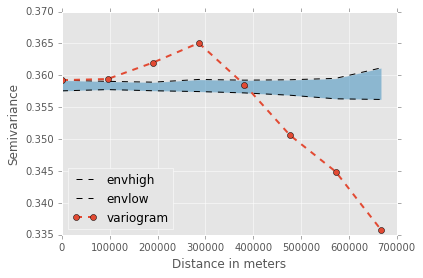

In [34]:
vg = tools.Variogram(section,'residuals1')
#vg.calculate_empirical(n_bins=50)
%time vg.plot(num_iterations=90,n_bins=10,refresh=True)

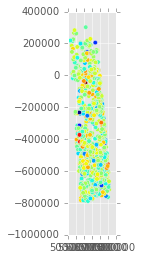

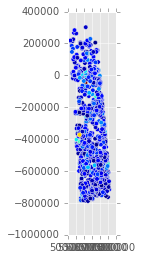

In [35]:
# COnsider the the following subregion
section = new_data[lambda x:  (x.LON > -90) & (x.LON < -88) & (x.LAT > 30) & (x.LAT < 40) ]
section.plot(column='residuals1')
section.plot(column='plotBiomass')

CPU times: user 19.1 s, sys: 12 ms, total: 19.1 s
Wall time: 19.1 s


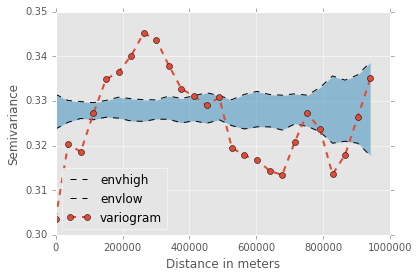

In [36]:
vg = tools.Variogram(section,'residuals1')
#vg.calculate_empirical(n_bins=50)
%time vg.plot(num_iterations=90,n_bins=30,refresh=True)

In [37]:
xx = pd.DataFrame({'dist' : vg.distance_coordinates.flatten() , 'y' : vg.distance_responses.flatten()})

## Now with distance restriction (experimental!)

CPU times: user 8.58 s, sys: 16 ms, total: 8.59 s
Wall time: 8.61 s


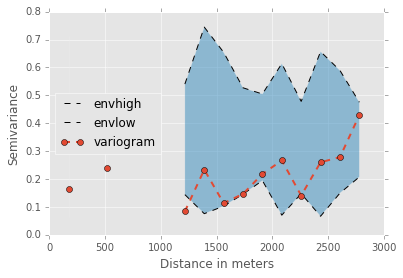

In [38]:
vg = tools.Variogram(section,'residuals1',using_distance_threshold=3000)
#vg.calculate_empirical(n_bins=50)
%time vg.plot(num_iterations=80,n_bins=20,refresh=True,with_envelope=True)

# Model Fitting Using a GLM 

The general model will have the form:
$$ Biomass(x,y) = \beta_1 AET + \beta_2 Age + Z(x,y) + \epsilon $$
Where:
$\beta_1$ and $\beta_2$ are model parameters, $Z(x,y)$ is the *Spatial Autocorrelation* process and $\epsilon \sim N(0,\sigma^2)$

In [39]:
len(data.lon)
#X = data[['AET','StandAge','lon','lat']]
#X = section[['SppN','lon','lat']]
#X = section[['SppN','newLon','newLat']]
X = section[['newLon','newLat']]
#Y = section['plotBiomass']
logY = section['logBiomass']
Y = section[['residuals1']]
#Y = data[['SppN']]
## First step in spatial autocorrelation
#Y = pd.DataFrame(np.zeros(len(Y)))
## Let´s take a small sample only for the spatial autocorrelation
import numpy as np
sample_size = 2000
randindx = np.random.randint(0,X.shape[0],sample_size)
nX = X.loc[randindx]
nY = Y.loc[randindx]


In [40]:
# Import GPFlow
import GPflow as gf
k = gf.kernels.Matern12(2, active_dims = [0,1],lengthscales=1000 )
#k = gf.kernels.Matern12(2,lengthscales=700000) + gf.kernels.Constant?

In [41]:
#k = gf.kernels.RBF(2,variance=2.0,lengthscales=4000) + gf.kernels.RBF(2,variance=2.0,lengthscales=700000) + gf.kernels.Constant(2,variance=1.0,active_dims=[0,1])

In [42]:
model = gf.gpr.GPR(section[['newLon','newLat']].as_matrix(),section.residuals1.values.reshape(-1,1),k)

In [43]:
%time model.optimize()

CPU times: user 29.5 s, sys: 2.85 s, total: 32.4 s
Wall time: 12.3 s


      fun: 759.26904291208223
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([  2.79227814e-06,   6.89431407e-03,  -0.00000000e+00])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 59
      nit: 43
   status: 0
  success: True
        x: array([  1.19710876e+03,  -8.57742282e-01,  -2.55571903e+03])

In [81]:
model.get_parameter_dict()

{'name.kern.lengthscales': array([ 1197.10875932]),
 'name.kern.variance': array([ 0.35355406]),
 'name.likelihood.variance': array([  1.00000000e-06])}

# Hasta Aqui!, Lo dem'as son tonterias y retazos

In [83]:
import numpy as np
Nn = 300
dsc = section
predicted_x = np.linspace(min(dsc.newLon),max(dsc.newLon),Nn)
predicted_y = np.linspace(min(dsc.newLat),max(dsc.newLat),Nn)
Xx, Yy = np.meshgrid(predicted_x,predicted_y)
## Fake richness
fake_sp_rich = np.ones(len(Xx.ravel()))
predicted_coordinates = np.vstack([ Xx.ravel(), Yy.ravel()]).transpose()
#predicted_coordinates = np.vstack([section.SppN, section.newLon,section.newLat]).transpose()

In [84]:
predicted_coordinates.shape

(90000, 2)

In [92]:
means,variances = model.predict_y(predicted_coordinates)

In [101]:
variances = np.array(variances)
means = np.array(means)

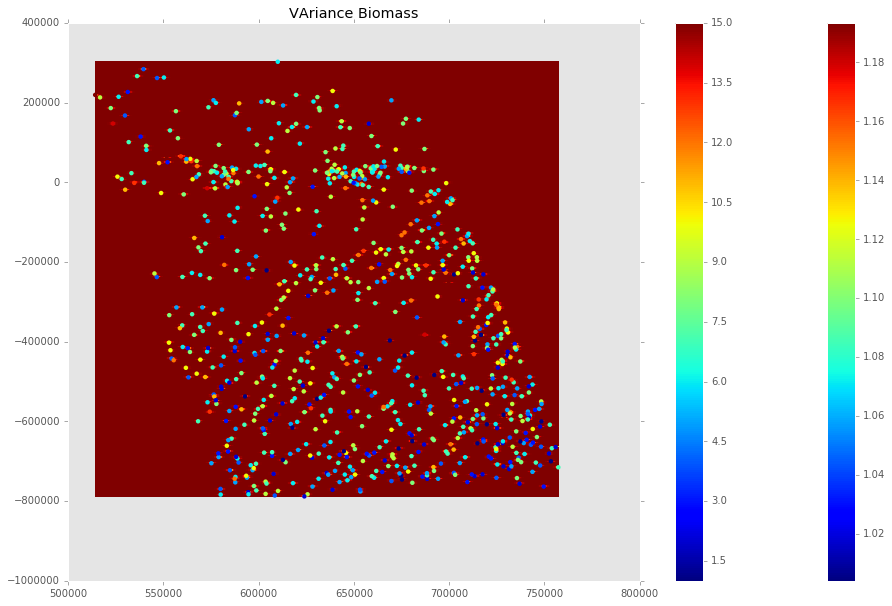

In [102]:
fig = plt.figure(figsize=(16,10), dpi= 80, facecolor='w', edgecolor='w')
#plt.pcolor(Xx,Yy,np.sqrt(variances.reshape(Nn,Nn))) #,cmap=plt.cm.Greens)
plt.pcolormesh(Xx,Yy,np.sqrt(variances.reshape(Nn,Nn)))
plt.colorbar()
plt.scatter(dsc.newLon,dsc.newLat,c=dsc.SppN,edgecolors='')
plt.title("VAriance Biomass")
plt.colorbar()

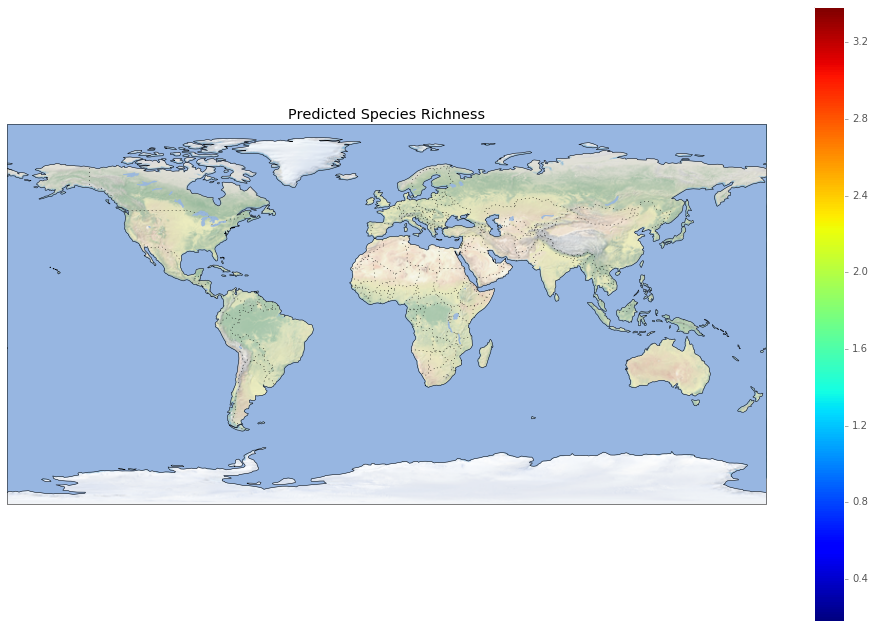

In [104]:
import cartopy
plt.figure(figsize=(17,11))

proj = cartopy.crs.PlateCarree()
ax = plt.subplot(111, projection=proj)


ax = plt.axes(projection=proj)
#algo = new_data.plot(column='SppN',ax=ax,cmap=colormap,edgecolors='')


#ax.set_extent([-93, -70, 30, 50])
#ax.set_extent([-100, -60, 20, 50])
#ax.set_extent([-95, -70, 25, 45])

#ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.add_feature(cartopy.feature.LAKES, alpha=0.9)
ax.stock_img()
#ax.add_geometries(new_data.geometry,crs=cartopy.crs.PlateCarree())
#ax.add_feature(cartopy.feature.RIVERS)
mm = ax.pcolormesh(Xx,Yy,means.reshape(Nn,Nn),transform=proj )
#cs = plt.contour(Xx,Yy,np.sqrt(variances).reshape(Nn,Nn),linewidths=2,cmap=plt.cm.Greys_r,linestyles='dotted')
cs = plt.contour(Xx,Yy,means.reshape(Nn,Nn),linewidths=2,colors='k',linestyles='dotted',levels=[4.0,5.0,6.0,7.0,8.0])
plt.clabel(cs, fontsize=16,inline=True,fmt='%1.1f')
#ax.scatter(new_data.lon,new_data.lat,c=new_data.error,edgecolors='',transform=proj,cmap=plt.cm.Greys,alpha=0.2)
plt.colorbar(mm)
plt.title("Predicted Species Richness")


#(x.LON > -90) & (x.LON < -80) & (x.LAT > 40) & (x.LAT < 50)